PCR

数据预处理：缺失值填补；异常检测以及归一化，过采样

In [ ]:
!pip install joblib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
import joblib

Read DataSet

In [ ]:
# Read dataset from a excel file
def readFromExcel(file_path):
    df = pd.read_excel(file_path)
    return df

In [ ]:
data=readFromExcel("TrainDataset2023.xls")

In [ ]:
test_data=readFromExcel("TestDatasetExample.xls")

Deal Nan value

In [ ]:
# Replace 999 with NaN
# Save this processing dataset to a excel file as FilledEmptyDataset.xlsx
def handleNaN(df):

    df_changed = df.replace(999, np.nan, inplace=False)

    # If NaN shows in pCR and RFS, drop this row
    df_handle = df_changed.dropna(subset=['pCR (outcome)', 'RelapseFreeSurvival (outcome)'])

    # Use median value to replace NaN
    df_filled = df_handle.fillna(df_handle.median(), inplace=False)

    # Reset the index for next step
    df_filled = df_filled.reset_index(drop=True)

    return df_filled

In [ ]:
data=handleNaN(data)

<ipython-input-18-cd54b87d8272>:11: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_filled = df_handle.fillna(df_handle.median(), inplace=False)


In [ ]:
test_data.replace(999,np.nan,inplace=True)
test_data.fillna(test_data.median(), inplace=True)

<ipython-input-20-8c5fe0193109>:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_data.fillna(test_data.median(), inplace=True)


CheckOutliers

In [ ]:
# Find outliers and assign values for them
# Save this processing dataset to a excel file as HandleOutliersDataset.xlsx
def checkOutliers(dataFrame):

    # Extract data after 13th cols
    df = dataFrame.iloc[:, 13:]
    imputer = KNNImputer(n_neighbors=3)
    for column in df.columns:

        # Use boxplots theory to find the outliers and replace them with nan
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3-q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df.loc[(df[column] > upper_bound) | (df[column] < lower_bound), column] = np.nan

    # Use KNNImputer give value to outliers
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    # Concatenate all columns
    result_df = pd.concat([dataFrame.iloc[:, :13], df], axis=1)

    return result_df

In [ ]:
data=checkOutliers(data)

imbalence using oversampling

In [ ]:
def over_sampling(dataFrame):
    y=dataFrame["pCR (outcome)"]
    x=dataFrame.drop(["pCR (outcome)","ID","RelapseFreeSurvival (outcome)"],axis=1)

    x_resample,y_resample=SMOTE().fit_resample(x,y)

    return pd.concat([y_resample,x_resample],axis=1)

In [ ]:
data["pCR (outcome)"].value_counts()

0.0    311
1.0     84
Name: pCR (outcome), dtype: int64

In [ ]:
data=over_sampling(data)

In [ ]:
data["pCR (outcome)"].value_counts()

1.0    311
0.0    311
Name: pCR (outcome), dtype: int64

In [ ]:
data.dtypes

pCR (outcome)                float64
Age                          float64
ER                             int64
PgR                          float64
HER2                         float64
                              ...   
original_ngtdm_Busyness      float64
original_ngtdm_Coarseness    float64
original_ngtdm_Complexity    float64
original_ngtdm_Contrast      float64
original_ngtdm_Strength      float64
Length: 118, dtype: object

In [ ]:
index_of_start = data.columns.get_loc('original_shape_Elongation')
print("Index of column:", index_of_start)

Index of column: 11


Normilization

In [ ]:
# Normalize the dataset
# Save this processing dataset to a excel file as ProcessedDataset.xlsx
# This is the final step for preprocessing
def normData(dataFrame):

    # Extract specific columns
    df = pd.concat([dataFrame['Age'], dataFrame.iloc[:, 11:]], axis=1)
    result_df=dataFrame.copy()
    for column in df.columns:

        # Make a rule to determine if there is a value out of the range [0, 1] in every column
        is_between_0_and_1 = (df[column] >= 0) & (df[column] <= 1)

        # Use all() to check whether all data in this column follow the rule, if not then normalize this column
        if is_between_0_and_1.all() == False:

            # Use MinMaxScaler to normalize selected column
            scaler = MinMaxScaler()
            df[[column]] = scaler.fit_transform(df[[column]])
            result_df[column]=df[column]
    return result_df

In [ ]:
data=normData(data)

In [ ]:
display(data)

,pCR (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1.0,0.318004,0,0.000000,0.000000,1.000000,3.000000,3.000000,1.000000,1.000000,...,0.517172,0.375126,0.732818,0.002314,0.193019,0.056520,0.000768,0.182615,0.004457,0.000758
1,0.0,0.282670,1,1.000000,0.000000,0.000000,3.000000,3.000000,1.000000,1.000000,...,0.444391,0.444391,0.643558,0.005612,0.117977,0.168310,0.004383,0.032012,0.001006,0.003685
2,1.0,0.141335,0,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,0.000000,...,0.534549,0.534549,0.477239,0.006752,0.076597,0.096060,0.007584,0.024062,0.000529,0.006447
3,0.0,0.212003,0,0.000000,0.000000,1.000000,3.000000,3.000000,1.000000,1.000000,...,0.506185,0.506185,0.513896,0.003755,0.345014,0.132643,0.005424,0.013707,0.000178,0.004543
4,0.0,0.671342,1,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,...,0.462282,0.462282,0.575707,0.006521,0.062937,0.112154,0.006585,0.034148,0.001083,0.005626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,1.0,0.633374,0,0.315024,0.684976,0.000000,2.315024,1.630049,1.000000,0.684976,...,0.487594,0.487594,0.563680,0.005246,0.051158,0.107824,0.009539,0.049142,0.003908,0.008328
618,1.0,0.471600,0,0.000000,0.400274,0.599726,2.000000,1.000000,1.400274,0.000000,...,0.223154,0.218426,0.354872,0.003987,0.007156,0.029556,0.011848,0.053656,0.005158,0.008552
619,1.0,0.653372,0,0.160908,0.160908,0.839092,2.160908,1.321817,1.000000,0.000000,...,0.451089,0.441178,0.291936,0.000924,0.204980,0.495287,0.002052,0.142354,0.002998,0.001880
620,1.0,0.800612,0,0.000000,0.796245,0.203755,2.203755,1.407511,1.000000,0.203755,...,0.365427,0.365427,0.760893,0.003106,0.398679,0.078177,0.000744,0.090936,0.008652,0.000667


In [ ]:
test_data=normData(test_data)

In [ ]:
display(test_data)

,ID,Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002728,0.000000,0,0,0,1,3,3,1.0,0,...,0.194591,0.194591,0.000000,0.001281,1.000000,0.537233,0.002335,0.109755,0.013383,0.002051
1,TRG002649,1.000000,0,0,1,0,2,1,1.0,0,...,0.309999,0.309996,0.137173,0.007253,0.000000,0.000000,0.011285,0.055890,0.003163,0.009553
2,TRG002628,0.433714,0,0,0,1,3,3,1.0,1,...,0.328377,0.328377,1.000000,0.003185,0.859655,1.000000,0.001334,0.101628,0.010844,0.001194


Random Forest feature importance

In [ ]:
# Divide feature matrix x and label y
y = data["pCR (outcome)"]
x = data.drop(["pCR (outcome)"], axis=1)

In [ ]:
submit_x=test_data.drop(["ID"],axis=1)

In [ ]:
def show_feature_importances(x,y,N=60):
  # RandomForest Feature Selection

  randomForest = RandomForestClassifier(random_state=42)

  # Train the randomForest
  randomForest.fit(x, y)

  # Obtain features importances
  feature_importances = randomForest.feature_importances_

  # Create a DataFrame to show every feature and importance
  feature_importances_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importances})

  # Sort features by their importances
  feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

  # Choose the first 20 features of highest importance
  selected_features = feature_importances_df['Feature'].head(N).tolist()


  # Select top N features
  top_N_features = feature_importances_df.iloc[:N, :]


  features_list = np.ravel(top_N_features["Feature"].tolist())


  X = x[features_list]
  #Plot the picture of top_N_features
  plt.figure(figsize=(20, 12))
  bars = plt.bar(feature_importances_df['Feature'], feature_importances_df['Importance'])

  for i, bar in enumerate(bars):
      if feature_importances_df.iloc[i]['Feature'] in top_N_features['Feature'].values:
          bar.set_color('red')

  plt.xticks(rotation=45, ha='right')
  for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
      if feature_importances_df['Feature'].iloc[i] in top_N_features['Feature'].values:
          label.set_color('red')

  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.title('Feature Importance from Random Forest')
  plt.show()
  return features_list


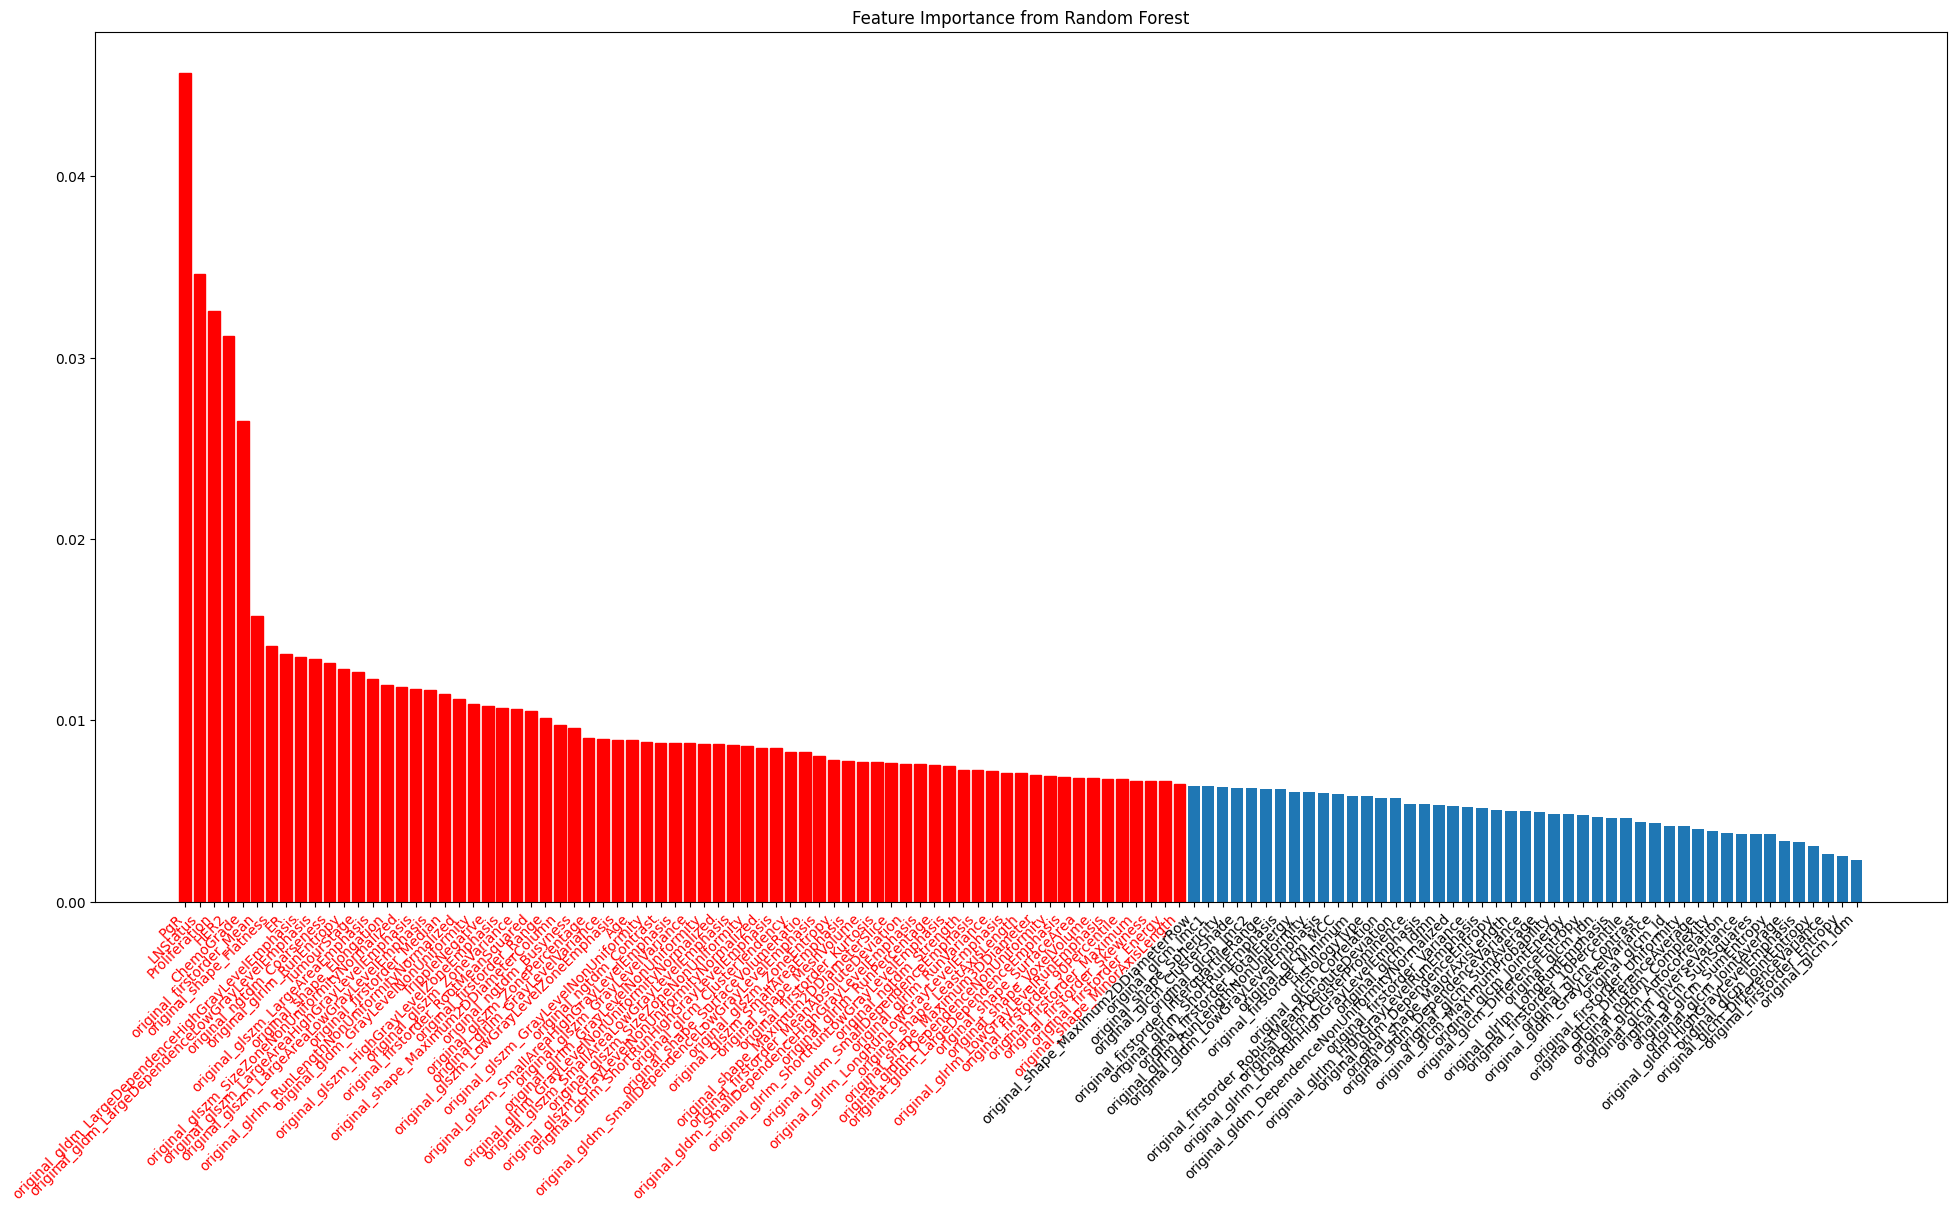

In [ ]:
features_list=show_feature_importances(x,y,70)

In [ ]:
joblib.dump(features_list,'FeaturelistForPCR')

['/content/drive/MyDrive/FeaturelistForPCR']

In [ ]:
x=x[features_list]
submit_x=submit_x[features_list]

PCA

In [ ]:
# PCA dimensionality reduction
n_comp = 40 # 选择要保留的主成分数量
pca = PCA(n_components=n_comp)

# 对标准化后的数据进行PCA变换
principal_components = pca.fit_transform(x)

# 将主成分转换为数据框
columns = [f"PC{i+1}" for i in range(n_comp)]
pca_df = pd.DataFrame(data=principal_components, columns=columns)

display(pca_df)
# # 可以查看每个主成分的方差解释比例
# explained_variance_ratio = pca.explained_variance_ratio_
# print("Explained Variance Ratio:", explained_variance_ratio)

# # 可以选择保留足够的主成分，使得累积的方差解释比例达到一个满意的阈值
# cumulative_explained_variance_ratio = explained_variance_ratio.cumsum()
# print("Cumulative Explained Variance Ratio:", cumulative_explained_variance_ratio)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40
0,-0.914962,1.490606,0.381345,-0.080231,-0.437328,0.557195,0.080517,-0.090344,0.065277,-0.229129,...,0.222315,-0.013314,-0.013999,0.017790,0.258979,-0.012617,-0.081532,-0.117034,-0.018838,0.073598
1,-0.174952,0.882252,0.415067,1.549801,-0.421744,0.383540,-0.188951,-0.378982,-0.611794,-0.347007,...,0.005465,0.026486,0.054342,0.061990,0.037534,-0.020710,-0.030169,-0.009129,0.006491,0.021177
2,-0.560859,-0.214839,-0.651374,-0.822199,-0.183730,-0.648169,-0.164684,-0.326647,-0.845824,-0.106331,...,0.009102,-0.115637,0.047438,-0.057978,0.026021,-0.033403,-0.069701,0.011358,-0.032277,-0.006605
3,0.802562,1.833122,0.291220,0.038530,-0.276920,-0.018652,0.360138,-0.437287,-0.815555,-0.402926,...,0.014822,0.034029,-0.056635,-0.048480,-0.039288,-0.032300,-0.017980,0.018034,0.026988,0.005204
4,-0.555835,-0.778124,-0.275101,0.235963,-0.366429,-0.857386,-0.049365,-0.340871,-0.654509,0.561996,...,0.014992,0.039295,0.012997,0.065475,-0.004800,0.009823,-0.014701,-0.029187,0.018587,0.017649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,-0.883857,-0.248472,0.116127,0.153740,0.021943,-0.220013,0.620257,-0.302674,-0.171230,-0.281487,...,0.005874,0.013179,0.001079,0.001984,-0.006747,0.002352,0.002415,-0.007013,0.003598,-0.007741
618,-1.924476,-0.675405,-0.719802,-0.536170,-0.088876,-0.118073,0.022735,0.260983,-0.030330,-0.115734,...,-0.069055,0.153520,0.029840,0.005661,-0.000720,0.011086,0.023603,-0.016368,0.056208,-0.033789
619,-0.891834,-0.101529,-0.358716,-0.714495,-0.218189,-0.374744,-0.258569,-0.022533,0.443144,0.306545,...,0.034617,-0.027123,-0.050707,0.024502,-0.025853,-0.064503,-0.080085,0.059587,-0.003102,-0.013204
620,0.263477,0.057176,-1.004668,-0.195437,0.754897,0.089955,0.199840,-0.205741,0.230649,0.126626,...,-0.044620,-0.000747,0.007810,0.008586,-0.005227,0.005269,-0.001348,-0.023625,-0.009683,0.003485


In [ ]:
joblib.dump(pca,"PCAforPCR")

['/content/drive/MyDrive/PCAforPCR']

In [ ]:
display(submit_x)

,PgR,LNStatus,Proliferation,HER2,ChemoGrade,original_firstorder_Mean,original_shape_Flatness,ER,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,...,original_gldm_DependenceNonUniformity,original_gldm_LargeDependenceEmphasis,original_shape_SurfaceArea,original_shape_VoxelVolume,original_glrlm_LowGrayLevelRunEmphasis,original_firstorder_90Percentile,original_firstorder_Maximum,original_firstorder_Skewness,original_firstorder_Energy,original_shape_MinorAxisLength
0,0,0,3,0,3,0.000000,0.520922,0,1.000000,1.000000,...,0.558131,1.000,0.211041,0.399879,0.586090,0.000000,0.000000,0.177252,0.039648,0.000000
1,0,0,1,1,2,1.000000,0.500237,0,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.383514,1.000000,0.731767,1.000000,0.000000,0.250806
2,0,1,3,0,3,0.837693,0.487975,0,0.961495,0.959654,...,1.000000,0.961,1.000000,1.000000,0.541780,0.777747,1.000000,0.000000,1.000000,1.000000


In [ ]:
# 对标准化后的数据进行PCA变换

principal_components_submit = pca.transform(submit_x)

# 将主成分转换为数据框
pca_submit_x = pd.DataFrame(data=principal_components_submit, columns=columns)

display(pca_submit_x)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40
0,-0.374318,2.007005,-0.416021,0.397784,-1.212098,-1.459923,0.392928,0.587719,0.783078,-0.024162,...,-0.072085,0.050025,-0.175799,0.016712,-0.374599,0.131539,0.040486,-0.055650,0.005991,-0.028732
1,-0.693647,-1.125522,0.835455,-1.035582,1.116534,0.213212,0.056621,0.589652,-0.051689,0.002444,...,-0.091514,0.058735,-0.065085,-0.020214,0.206488,0.026041,0.046334,0.075547,-0.149178,-0.077020
2,3.029374,2.343016,-0.191500,-0.185325,0.351999,0.476506,-0.029062,-0.809434,-0.002776,0.185126,...,0.070553,0.047549,-0.067701,-0.033874,-0.320973,0.068166,0.084264,0.020876,0.065046,-0.119650


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.3, random_state=42)

Cross Validation

In [ ]:
kf=KFold(n_splits=5)

random_state=31

# Add model
models=[]
models.append(LogisticRegression(random_state=random_state))
models.append(DecisionTreeClassifier(random_state=random_state))
models.append(SVC(random_state=random_state))
models.append(MLPClassifier(random_state=random_state))

# Store cv results
cv_results=[]

for model in models:
    #metrics use f1-scere使用accuracy来评价模型
    cv_results.append(cross_val_score(model,pca_df,y=y,scoring="balanced_accuracy",cv=kf,n_jobs=4))

# Store means
cv_means = []

# Store standard deviation
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["LogisticRegression",
                                    "DecisionTreeClassifier",
                                    "SVM",
                                    "MultipleLayerPerceptron"
                                    ]})
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.689579,0.024306,LogisticRegression
1,0.726875,0.081460,DecisionTreeClassifier
2,0.784379,0.064139,SVM
3,0.799983,0.087790,MultipleLayerPerceptron


对神经网络模型调优

In [ ]:
mlp=MLPClassifier(random_state=random_state)
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
}

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=MLPClassifier(random_state=31), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 50)],
                         'solver': ['adam', 'sgd']},
             scoring='accuracy', verbose=1)

In [ ]:
print(f"best_params:{grid_search.best_params_}")
best_model = grid_search.best_estimator_

best_params:{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'solver': 'adam'}


In [ ]:

accuracy=balanced_accuracy_score(y_test,best_model.predict(X_test))
print(accuracy)

0.8128574696865706


Write predict answer to csv

In [ ]:
submit__y=best_model.predict(submit_x)
submit_df=pd.DataFrame({"ID":test_data["ID"],"pCR (outcome)":submit__y})
submit_df.to_csv("FinalTestPCR.csv")

RFS

数据预处理：缺失值填补；异常检测以及归一化，过采样

In [35]:
!pip install joblib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.svm import SVC,SVR
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestRegressor
import joblib

Read DataSet

In [3]:
# Read dataset from a excel file
def readFromExcel(file_path):
    df = pd.read_excel(file_path)
    return df

In [6]:
data=readFromExcel("TrainDataset2023.xls")

In [8]:
test_data=readFromExcel("TestDatasetExample.xls")

Deal Nan value

In [9]:
# Replace 999 with NaN
# Save this processing dataset to a excel file as FilledEmptyDataset.xlsx
def handleNaN(df):

    df_changed = df.replace(999, np.nan, inplace=False)

    # If NaN shows in pCR and RFS, drop this row
    df_handle = df_changed.dropna(subset=['pCR (outcome)', 'RelapseFreeSurvival (outcome)'])

    # Use median value to replace NaN
    df_filled = df_handle.fillna(df_handle.median(), inplace=False)

    # Reset the index for next step
    df_filled = df_filled.reset_index(drop=True)

    return df_filled

In [10]:
data=handleNaN(data)

<ipython-input-9-cd54b87d8272>:11: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_filled = df_handle.fillna(df_handle.median(), inplace=False)


In [11]:
test_data.replace(999,np.nan,inplace=True)
test_data.fillna(test_data.median(), inplace=True)

<ipython-input-11-8c5fe0193109>:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_data.fillna(test_data.median(), inplace=True)


CheckOutliers

In [12]:
# Find outliers and assign values for them
# Save this processing dataset to a excel file as HandleOutliersDataset.xlsx
def checkOutliers(dataFrame):

    # Extract data after 13th cols
    df = dataFrame.iloc[:, 13:]
    imputer = KNNImputer(n_neighbors=3)
    for column in df.columns:

        # Use boxplots theory to find the outliers and replace them with nan
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3-q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df.loc[(df[column] > upper_bound) | (df[column] < lower_bound), column] = np.nan

    # Use KNNImputer give value to outliers
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    # Concatenate all columns
    result_df = pd.concat([dataFrame.iloc[:, :13], df], axis=1)

    return result_df

In [13]:
data=checkOutliers(data)

In [14]:
data.dtypes

ID                                object
pCR (outcome)                    float64
RelapseFreeSurvival (outcome)    float64
Age                              float64
ER                                 int64
                                  ...   
original_ngtdm_Busyness          float64
original_ngtdm_Coarseness        float64
original_ngtdm_Complexity        float64
original_ngtdm_Contrast          float64
original_ngtdm_Strength          float64
Length: 120, dtype: object

In [15]:
index_of_start = data.columns.get_loc('original_shape_Elongation')
print("Index of column of train:", index_of_start)

Index of column of train: 13


Normilization

In [16]:
# Normalize the dataset
# Save this processing dataset to a excel file as ProcessedDataset.xlsx
# This is the final step for preprocessing
def normData(dataFrame,star):

    # Extract specific columns
    df = pd.concat([dataFrame['Age'], dataFrame.iloc[:, star:]], axis=1)
    result_df=dataFrame.copy()
    for column in df.columns:

        # Make a rule to determine if there is a value out of the range [0, 1] in every column
        is_between_0_and_1 = (df[column] >= 0) & (df[column] <= 1)

        # Use all() to check whether all data in this column follow the rule, if not then normalize this column
        if is_between_0_and_1.all() == False:

            # Use MinMaxScaler to normalize selected column
            scaler = MinMaxScaler()
            df[[column]] = scaler.fit_transform(df[[column]])
            result_df[column]=df[column]
    return result_df

In [17]:
data=normData(data,index_of_start)

In [18]:
display(data)

,ID,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002174,1.0,144.000000,0.318004,0,0.0,0.0,1.0,3.0,3.0,...,0.517172,0.375126,0.732818,0.002314,0.193019,0.056520,0.000768,0.182615,0.004457,0.000758
1,TRG002178,0.0,142.000000,0.282670,1,1.0,0.0,0.0,3.0,3.0,...,0.444391,0.444391,0.643558,0.005612,0.117977,0.168310,0.004383,0.032012,0.001006,0.003685
2,TRG002204,1.0,135.000000,0.141335,0,0.0,0.0,1.0,2.0,1.0,...,0.534549,0.534549,0.477239,0.006752,0.076597,0.096060,0.007584,0.024062,0.000529,0.006447
3,TRG002206,0.0,12.000000,0.212003,0,0.0,0.0,1.0,3.0,3.0,...,0.506185,0.506185,0.513896,0.003755,0.345014,0.132643,0.005424,0.013707,0.000178,0.004543
4,TRG002210,0.0,109.000000,0.671342,1,0.0,0.0,0.0,2.0,1.0,...,0.462282,0.462282,0.575707,0.006521,0.062937,0.112154,0.006585,0.034148,0.001083,0.005626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,TRG002948,0.0,54.500000,0.627175,1,0.0,1.0,0.0,3.0,2.0,...,0.476493,0.476493,0.467416,0.003229,0.115740,0.052544,0.013766,0.018042,0.000288,0.012257
391,TRG002954,0.0,49.250000,0.199636,0,0.0,0.0,1.0,3.0,3.0,...,0.418382,0.418382,0.632433,0.004243,0.049989,0.443359,0.002228,0.136015,0.002686,0.002098
392,TRG002958,0.0,48.500000,0.535307,0,0.0,0.0,1.0,2.0,1.0,...,0.527779,0.527778,0.177099,0.003728,0.010604,0.002821,0.004698,0.007380,0.000037,0.004613
393,TRG002961,0.0,47.500000,0.809144,1,0.0,0.0,0.0,3.0,3.0,...,0.313693,0.313693,0.808390,0.001112,0.998739,0.579901,0.001372,0.054063,0.003697,0.001368


In [19]:
index_of_start = test_data.columns.get_loc('original_shape_Elongation')
print("Index of column of train:", index_of_start)

Index of column of train: 11


In [20]:
test_data=normData(test_data,index_of_start)

In [21]:
display(test_data)

,ID,Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002728,0.000000,0,0,0,1,3,3,1.0,0,...,0.194591,0.194591,0.000000,0.001281,1.000000,0.537233,0.002335,0.109755,0.013383,0.002051
1,TRG002649,1.000000,0,0,1,0,2,1,1.0,0,...,0.309999,0.309996,0.137173,0.007253,0.000000,0.000000,0.011285,0.055890,0.003163,0.009553
2,TRG002628,0.433714,0,0,0,1,3,3,1.0,1,...,0.328377,0.328377,1.000000,0.003185,0.859655,1.000000,0.001334,0.101628,0.010844,0.001194


Random Forest feature importance

In [22]:
# Divide feature matrix x and label y
y = data["RelapseFreeSurvival (outcome)"]
x = data.drop(["pCR (outcome)","RelapseFreeSurvival (outcome)","ID"], axis=1)

In [23]:
submit_x=test_data.drop(["ID"],axis=1)

In [24]:
def show_feature_importances(x,y,N=60):
  # RandomForest Feature Selection

  randomForest = RandomForestRegressor(random_state=42)

  # Train the randomForest
  randomForest.fit(x, y)

  # Obtain features importances
  feature_importances = randomForest.feature_importances_

  # Create a DataFrame to show every feature and importance
  feature_importances_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importances})

  # Sort features by their importances
  feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

  # Choose the first 20 features of highest importance
  selected_features = feature_importances_df['Feature'].head(N).tolist()


  # Select top N features
  top_N_features = feature_importances_df.iloc[:N, :]


  features_list = np.ravel(top_N_features["Feature"].tolist())


  X = x[features_list]
  #Plot the picture of top_N_features
  plt.figure(figsize=(20, 12))
  bars = plt.bar(feature_importances_df['Feature'], feature_importances_df['Importance'])

  for i, bar in enumerate(bars):
      if feature_importances_df.iloc[i]['Feature'] in top_N_features['Feature'].values:
          bar.set_color('red')

  plt.xticks(rotation=45, ha='right')
  for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
      if feature_importances_df['Feature'].iloc[i] in top_N_features['Feature'].values:
          label.set_color('red')

  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.title('Feature Importance from Random Forest')
  plt.show()
  return features_list


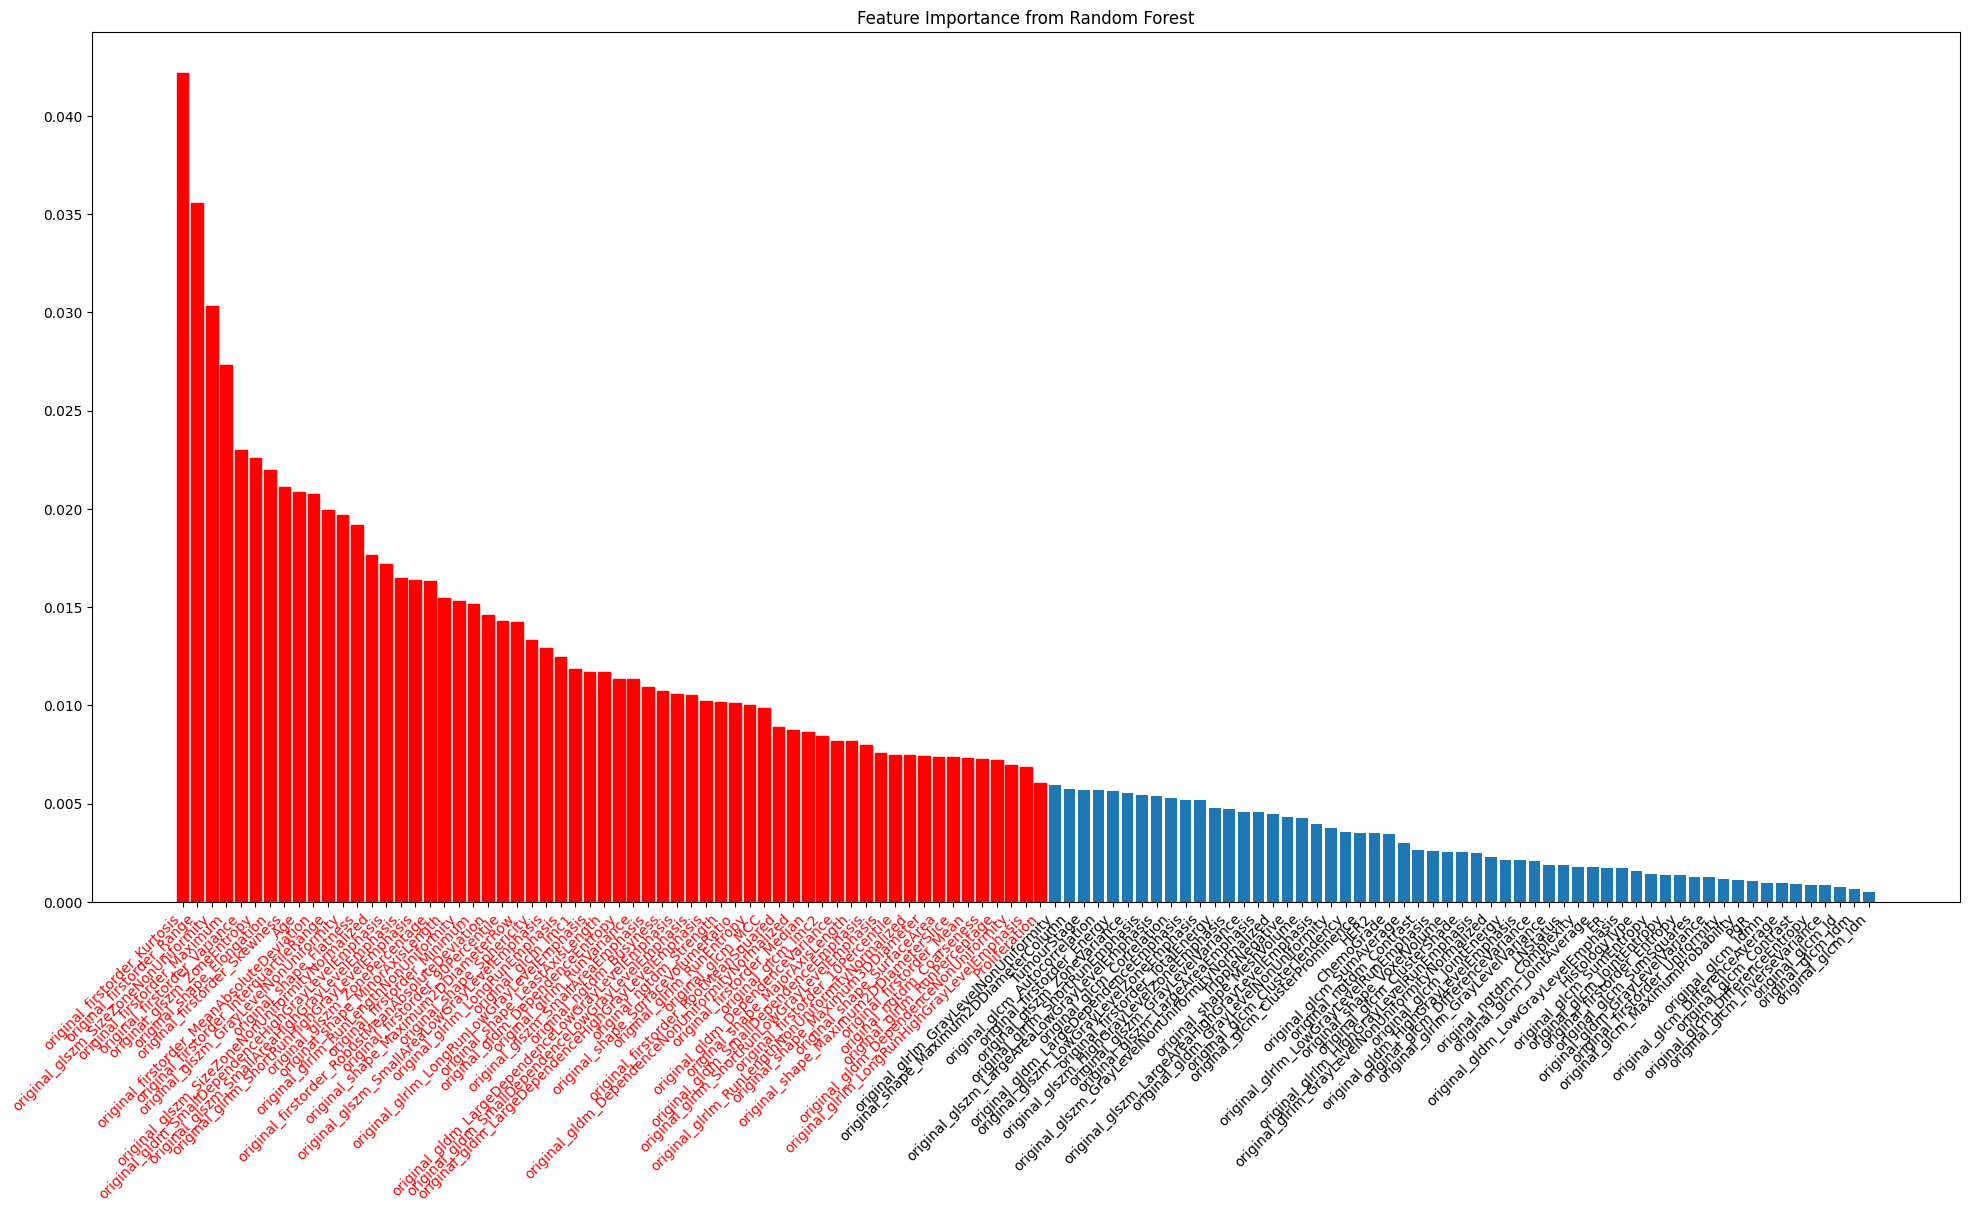

In [25]:
features_list=show_feature_importances(x,y,60)

In [36]:
joblib.dump(features_list,"/content/drive/MyDrive/FeaturelistForRFS")

['/content/drive/MyDrive/FeaturelistForRFS']

In [27]:
x=x[features_list]
submit_x=submit_x[features_list]

PCA

In [28]:
# PCA dimensionality reduction
n_comp = 16 # 选择要保留的主成分数量
pca = PCA(n_components=n_comp)

# 对标准化后的数据进行PCA变换
principal_components = pca.fit_transform(x)

# 将主成分转换为数据框
columns = [f"PC{i+1}" for i in range(n_comp)]
pca_df = pd.DataFrame(data=principal_components, columns=columns)

display(pca_df)
# # 可以查看每个主成分的方差解释比例
# explained_variance_ratio = pca.explained_variance_ratio_
# print("Explained Variance Ratio:", explained_variance_ratio)

# # 可以选择保留足够的主成分，使得累积的方差解释比例达到一个满意的阈值
# cumulative_explained_variance_ratio = explained_variance_ratio.cumsum()
# print("Cumulative Explained Variance Ratio:", cumulative_explained_variance_ratio)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
0,0.750461,1.280293,0.415365,0.085504,-0.460901,-0.553936,0.206077,-0.423525,0.198244,-0.208138,-0.119658,-0.063090,0.114407,-0.261859,0.502617,-0.133792
1,1.408393,0.652130,-0.169813,0.417173,0.192216,-0.497442,-0.212522,0.267379,-0.107158,-0.027788,0.116048,0.162397,-0.173883,0.173088,-0.077172,-0.047488
2,-0.213660,-0.258905,-0.813983,0.078263,0.461447,-0.535087,0.274067,0.186962,-0.442324,0.061260,0.100489,0.027779,0.066222,-0.202511,0.150252,0.038328
3,1.757675,0.237208,-0.335242,0.457094,0.404258,-0.651420,-0.056391,0.019982,0.053951,-0.114935,0.014732,-0.196468,-0.084955,0.043129,-0.272123,-0.094965
4,-0.290372,0.041775,-1.147768,-0.107120,0.369845,-0.152691,-0.155510,-0.094652,-0.053956,-0.020178,-0.167734,0.057209,0.055166,0.123401,-0.082508,0.052168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,0.279189,0.426303,-0.447822,0.629309,-0.206253,-0.316608,-0.151116,0.259707,0.158535,0.412444,-0.108742,0.034248,-0.122458,0.086977,-0.112841,0.022448
391,0.513422,1.439436,1.057174,-0.477385,-0.189291,-0.088217,0.287931,0.246994,0.193139,-0.315855,0.185665,-0.100761,0.091169,-0.007290,0.015459,-0.081303
392,-1.331821,0.440876,0.087341,0.756551,0.253305,0.184951,0.172063,-0.155410,-0.000544,-0.017563,0.083194,-0.095626,-0.199308,-0.199204,0.065389,-0.114612
393,1.567483,0.757164,-0.274338,-0.381510,-0.309560,0.122278,-0.122194,0.207314,0.203105,-0.137306,-0.114410,0.444018,0.274088,0.245015,-0.149789,-0.318735


In [29]:
display(submit_x)

,original_firstorder_Kurtosis,original_firstorder_Range,original_glszm_SizeZoneNonUniformity,original_firstorder_Maximum,original_firstorder_Variance,original_glszm_ZoneEntropy,original_shape_Elongation,original_firstorder_Skewness,Age,original_firstorder_MeanAbsoluteDeviation,...,original_glrlm_RunLengthNonUniformityNormalized,original_shape_Maximum3DDiameter,original_shape_SurfaceArea,original_shape_Maximum2DDiameterSlice,original_firstorder_Mean,original_ngtdm_Coarseness,original_glrlm_RunPercentage,original_gldm_DependenceNonUniformity,original_glrlm_LongRunHighGrayLevelEmphasis,Proliferation
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.621404,0.177252,0.000000,0.000000,...,0.183692,0.018755,0.211041,0.364869,0.000000,0.002335,0.206807,0.558131,0.982836,3
1,0.927264,0.509502,0.662692,0.731767,0.783658,0.137173,0.733284,1.000000,1.000000,0.700205,...,0.140892,0.000000,0.000000,0.000000,1.000000,0.011285,0.252044,0.000000,0.000000,1
2,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.703667,0.000000,0.433714,1.000000,...,0.160050,1.000000,1.000000,1.000000,0.837693,0.001334,0.205509,1.000000,1.000000,3


In [30]:
# 对标准化后的数据进行PCA变换

principal_components_submit = pca.transform(submit_x)

# 将主成分转换为数据框
pca_submit_x = pd.DataFrame(data=principal_components_submit, columns=columns)

display(pca_submit_x)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
0,1.506608,1.444578,-1.108581,-0.720206,-0.385492,0.300196,-0.085488,-0.066137,-0.359396,0.555717,0.357331,-0.240002,-0.704297,-0.420818,-0.435929,0.092681
1,-1.287537,-0.053292,0.635132,1.197098,0.413798,-0.054616,0.104868,0.196608,0.022482,-0.481461,-0.507259,0.749390,-0.463490,-0.201204,-0.188765,-0.380845
2,2.573402,-1.311050,1.353390,-1.019074,0.580557,0.350034,-0.620002,0.389310,0.650047,-0.255013,0.365057,-0.235925,-0.131580,0.160263,-0.201269,-0.028830


In [37]:
joblib.dump(pca,"PCAforRFS")

['/content/drive/MyDrive/PCAforRFS']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.3, random_state=42)

Cross Validation

In [34]:
kf=KFold(n_splits=5)



# Add model
models=[]
models.append(LinearRegression())
models.append(DecisionTreeRegressor())
models.append(SVR())
models.append(MLPRegressor())

# Store cv results
cv_results=[]

for model in models:

    #metrics use f1-scere使用accuracy来评价模型
    mse_scores = -cross_val_score(model, pca_df, y, cv=kf, scoring='neg_mean_absolute_error')
    cv_results.append(mse_scores)
# Store means
cv_means = []

# Store standard deviation
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["LinearRegression",
                                    "DecisionTreeRegressor",
                                    "SVR",
                                    "MultipleLayerPerceptron"
                                    ]})
cv_res

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

,CrossValMeans,CrossValerrors,Algorithm
0,23.735836,10.178033,LinearRegression
1,32.105696,5.151362,DecisionTreeRegressor
2,22.795589,10.799633,SVR
3,32.614378,14.330020,MultipleLayerPerceptron


对SVR模型调优

In [38]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# 准备数据
# X 和 y 是特征和目标变量

# 定义需要调优的参数网格
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly'],
}

# 创建 SVM 模型对象
svm = SVR()


# 实例化 GridSearchCV 对象
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# 进行网格搜索
grid_search.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='accuracy')

In [39]:
print(f"best_params:{grid_search.best_params_}")
best_model = grid_search.best_estimator_

best_params:{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


In [40]:

mae=mean_absolute_error(y_test,best_model.predict(X_test))
print(mae)

22.84452859865143


Write predict answer to csv

In [ ]:
submit__y=best_model.predict(submit_x)
submit_df=pd.DataFrame({"ID":test_data["ID"],"RelapseFreeSurvival (outcome)":submit__y})
submit_df.to_csv("FinalTestRFS.csv")